# Personal Info
- Name: Shanlei Gao
- Student ID: 112516422
- Email: gao.shanlei@stonybrook.edu

# Load Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime
import csv
import scipy.stats

In [2]:
# Get number of days passed since 2020-01-22
def date_index(date_string):
    year = int(date_string[0:4])
    month = int(date_string[5:7])
    day = int(date_string[8:10])
    d1 = datetime.datetime(2020, 1, 22)
    d2 = datetime.datetime(year, month, day)
    return (d2 - d1).days

In [3]:
de_confirmed = np.loadtxt("Datasets/States Data/5.csv", delimiter=",", encoding='utf-8-sig', usecols=((1)), skiprows=1)
fl_confirmed = np.loadtxt("Datasets/States Data/5.csv", delimiter=",", encoding='utf-8-sig', usecols=((2)), skiprows=1)
de_deaths = np.loadtxt("Datasets/States Data/5.csv", delimiter=",", encoding='utf-8-sig', usecols=((3)), skiprows=1)
fl_deaths = np.loadtxt("Datasets/States Data/5.csv", delimiter=",", encoding='utf-8-sig', usecols=((4)), skiprows=1)

date = []
csv_file=open('Datasets/States Data/5.csv')
csv_reader_lines = csv.reader(csv_file)
for one_line in csv_reader_lines:
    if one_line[0]!='Date':
        date.append(date_index(one_line[0]))

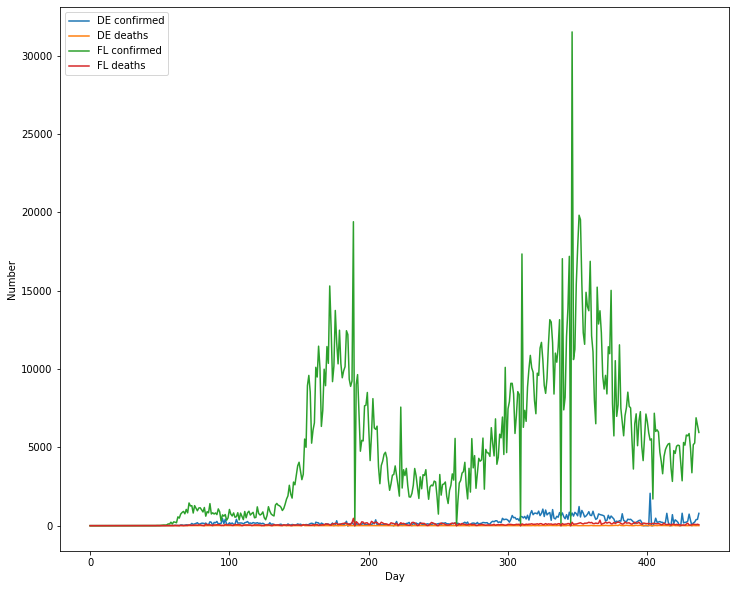

In [4]:
# Get daily data
de_confirmed_daily = [0]
fl_confirmed_daily = [0]
de_deaths_daily = [0]
fl_deaths_daily = [0]
for i in range(1, len(de_confirmed)):
    de_confirmed_daily.append(de_confirmed[i] - de_confirmed[i-1])
    fl_confirmed_daily.append(fl_confirmed[i] - fl_confirmed[i-1])
    de_deaths_daily.append(de_deaths[i] - de_deaths[i-1])
    fl_deaths_daily.append(fl_deaths[i] - fl_deaths[i-1])

plt.figure(figsize=(12,10))
plt.plot(date, de_confirmed_daily, label='DE confirmed')
plt.plot(date, de_deaths_daily, label='DE deaths')
plt.plot(date, fl_confirmed_daily, label='FL confirmed')
plt.plot(date, fl_deaths_daily, label='FL deaths')
plt.xlabel('Day')
plt.ylabel('Number')
plt.legend(loc='upper left')
plt.show()

# Clean Dataset

In [5]:
def tukey_outlier(input, alpha):
    sorted_data = sorted(input)
    n = len(input)
    count = 0

    q1 = sorted_data[math.ceil(n / 4)]
    q3 = sorted_data[math.ceil((3 * n) / 4)]
    iqr = q3 - q1

    for i in range(len(input)):
        if input[i] > q3 + alpha * iqr or input[i] < q1 - alpha * iqr:
            count += 1
            if input[i] != 0: # Except 0s
                input[i] = (input[i-1] + input[i-2])/2

    return count

In [6]:
outlier_alpha = 1.5
print('DE confirmed:', tukey_outlier(de_confirmed_daily, outlier_alpha), 'outliers detected.')
print('FL confirmed:', tukey_outlier(fl_confirmed_daily, outlier_alpha), 'outliers detected.')
print('DE deaths:', tukey_outlier(de_deaths_daily, outlier_alpha), 'outliers detected.')
print('FL deaths:', tukey_outlier(fl_deaths_daily, outlier_alpha), 'outliers detected.')

DE confirmed: 41 outliers detected.
FL confirmed: 5 outliers detected.
DE deaths: 24 outliers detected.
FL deaths: 3 outliers detected.


In [7]:
def daily_to_cum(daily):
    sum = 0
    cum = []
    for x in daily:
        sum += x
        cum.append(sum)
    return cum 


In [8]:
de_confirmed = daily_to_cum(de_confirmed_daily)
de_deaths = daily_to_cum(de_deaths_daily)
fl_confirmed = daily_to_cum(fl_confirmed_daily)
fl_deaths = daily_to_cum(fl_deaths_daily)

- Result: 
    - DE confirmed: 41 outliers detected.
    - FL confirmed: 5 outliers detected.
    - DE deaths: 24 outliers detected.
    - FL deaths: 3 outliers detected.
- For daily data, outliers are removed by replaced with average of the previous and next one.
- Then sum up daily data to get outlier-removed cumulative data.

# 2a: Time Series Analysis

In [9]:
def mse(estimator, truth):
    n = len(estimator)
    sum = 0
    for i in range(n):
        sum += (truth[i] - estimator[i]) ** 2
    return sum/n

In [10]:
def mape(estimator, truth):
    n = len(estimator)
    sum = 0
    for i in range(n):
        if truth[i] == 0:
            n -= 1
        else:
            sum += abs(truth[i] - estimator[i]) / truth[i]
    return (100 * sum) / n

## EWMA

In [11]:
def ewma(input, alpha):
    n = len(input)
    prediction = [input[0]]
    for i in range(1, n):
        last_observation = input[i-1]
        last_prediction = prediction[-1]
        prediction.append(alpha * last_observation + (1-alpha) * last_prediction)
    return prediction

In [12]:
def ewma_one_week(data, alpha):
    aug = data[date_index('2020-08-01'):date_index('2020-08-29')]
    true = data[date_index('2020-08-22'):date_index('2020-08-29')]
    predict = ewma(aug, alpha)[-7:]

    print('True value =', true)
    print('Predict value =', predict)
    print('MAPE =', mape(predict, true), '%')
    print('MSE =', mse(predict,true))
    # return predict

In [13]:
# EWMA with alpha=0.5
print('EWMA with alpha=0.5')
print('\nDE confirmed: ')
ewma_one_week(de_confirmed, 0.5)
print('\nFL confirmed: ')
ewma_one_week(fl_confirmed, 0.5)
print('\nDE deaths: ')
ewma_one_week(de_deaths, 0.5)
print('\nFL deaths: ')
ewma_one_week(fl_deaths, 0.5)

EWMA with alpha=0.5

DE confirmed: 
True value = [16828.0, 16895.0, 16942.0, 16962.0, 16986.0, 16976.0, 17083.0]
Predict value = [16709.58656692505, 16768.793283462524, 16831.896641731262, 16886.94832086563, 16924.474160432816, 16955.237080216408, 16965.618540108204]
MAPE = 0.5306679794392648 %
MSE = 9385.759339060727

FL confirmed: 
True value = [587256.0, 590230.0, 592488.0, 595161.0, 598381.0, 601650.0, 605465.0]
Predict value = [578467.9563293457, 582861.9781646729, 586545.9890823364, 589516.9945411682, 592338.9972705841, 595359.998635292, 598504.999317646]
MAPE = 1.128672834196662 %
MSE = 46170181.76240079

DE deaths: 
True value = [436.25, 436.25, 440.25, 439.25, 440.25, 440.25, 440.25]
Predict value = [433.49581146240234, 434.8729057312012, 435.5614528656006, 437.9057264328003, 438.57786321640015, 439.4139316082001, 439.83196580410004]
MAPE = 0.42609826300059556 %
MSE = 5.27732759264657

FL deaths: 
True value = [9744.5, 9795.5, 9867.5, 10050.5, 10203.5, 10338.5, 10427.5]
Predic

In [14]:
# EWMA with alpha = 0.7
print('EWMA with alpha = 0.7')
print('\nDE confirmed: ')
ewma_one_week(de_confirmed, 0.7)
print('\nFL confirmed: ')
ewma_one_week(fl_confirmed, 0.7)
print('\nDE deaths: ')
ewma_one_week(de_deaths, 0.7)
print('\nFL deaths: ')
ewma_one_week(fl_deaths, 0.7)

EWMA with alpha = 0.7

DE confirmed: 
True value = [16828.0, 16895.0, 16942.0, 16962.0, 16986.0, 16976.0, 17083.0]
Predict value = [16745.551564378715, 16803.265469313614, 16867.479640794085, 16919.643892238226, 16949.29316767147, 16974.987950301438, 16975.696385090432]
MAPE = 0.3675252945568383 %
MSE = 5060.396287771784

FL confirmed: 
True value = [587256.0, 590230.0, 592488.0, 595161.0, 598381.0, 601650.0, 605465.0]
Predict value = [580976.4174998556, 585372.1252499567, 588772.637574987, 591373.3912724961, 594024.7173817488, 597074.1152145247, 600277.2345643574]
MAPE = 0.7858895058795293 %
MSE = 22572975.902908426

DE deaths: 
True value = [436.25, 436.25, 440.25, 439.25, 440.25, 440.25, 440.25]
Predict value = [434.6959603637846, 435.7837881091354, 436.11013643274066, 439.0080409298222, 439.17741227894663, 439.928223683684, 440.15346710510516]
MAPE = 0.25673872763649824 %
MSE = 3.013244326023961

FL deaths: 
True value = [9744.5, 9795.5, 9867.5, 10050.5, 10203.5, 10338.5, 10427.5]


## AR

In [15]:
def ar(data, p):
    y = []
    x = []
    for i in range(len(data)-p):
        x.append([1]+data[i:i+p])
        y.append([data[i+p]])
    
    beta = np.dot(np.transpose(x), x)
    beta = np.linalg.inv(beta)
    beta = np.dot(beta, np.transpose(x))
    beta = np.dot(beta, y)

    feature = [1] + data[-p:]
    result = np.dot(feature, beta)[0]

    return result

In [16]:
def ar_one_week(data,p):
    aug_first3 = data[date_index('2020-08-01'):date_index('2020-08-22')]
    true = data[date_index('2020-08-22'):date_index('2020-08-29')]
    predict = []

    predict.append(ar(aug_first3, p))
    for i in range(6):
        aug_first3 = np.append(aug_first3, [true[i]])
        predict.append(ar(aug_first3, p))

    print('True value =', true)
    print('Predict value =', predict)
    print('MAPE =', mape(predict, true), '%')
    print('MSE =', mse(predict,true))
    # return predict

In [17]:
# AR(3)
print('AR(3)')
print('\nDE confirmed: ')
ar_one_week(de_confirmed, 3)
print('\nFL confirmed: ')
ar_one_week(fl_confirmed, 3)
print('\nDE deaths: ')
ar_one_week(de_deaths, 3)
print('\nFL deaths: ')
ar_one_week(fl_deaths, 3)

AR(3)

DE confirmed: 
True value = [16828.0, 16895.0, 16942.0, 16962.0, 16986.0, 16976.0, 17083.0]
Predict value = [16842.71575310638, 16918.198571333596, 16984.58735446166, 17028.460501805133, 17037.558173848483, 17051.709197117965, 17027.994868342103]
MAPE = 0.2770640642409507 %
MSE = 2628.728641311562

FL confirmed: 
True value = [587256.0, 590230.0, 592488.0, 595161.0, 598381.0, 601650.0, 605465.0]
Predict value = [587229.7467283518, 592065.7115944263, 593772.4800386173, 595329.5762093004, 598429.324961134, 602091.5508621987, 605294.1087547903]
MAPE = 0.09575661270329319 %
MSE = 753619.9262282973

DE deaths: 
True value = [436.25, 436.25, 440.25, 439.25, 440.25, 440.25, 440.25]
Predict value = [435.6573570192732, 437.99325482631593, 437.22888391902165, 440.18906936247026, 440.3242639408007, 441.2798909393159, 441.32516846081893]
MAPE = 0.27578364430194485 %
MSE = 2.2316192047546877

FL deaths: 
True value = [9744.5, 9795.5, 9867.5, 10050.5, 10203.5, 10338.5, 10427.5]
Predict value 

In [18]:
# AR(5)
print('AR(5)')
print('\nDE confirmed: ')
ar_one_week(de_confirmed, 5)
print('\nFL confirmed: ')
ar_one_week(fl_confirmed, 5)
print('\nDE deaths: ')
ar_one_week(de_deaths, 5)
print('\nFL deaths: ')
ar_one_week(fl_deaths, 5)

AR(5)

DE confirmed: 
True value = [16828.0, 16895.0, 16942.0, 16962.0, 16986.0, 16976.0, 17083.0]
Predict value = [16868.66422796663, 16928.88359570937, 16990.55933952239, 17036.258671796102, 17040.856736712125, 17053.323805394844, 17030.714846877883]
MAPE = 0.3215889427852308 %
MSE = 3199.4295666480707

FL confirmed: 
True value = [587256.0, 590230.0, 592488.0, 595161.0, 598381.0, 601650.0, 605465.0]
Predict value = [587007.5452938905, 591724.9658989512, 593458.1322872348, 595301.2497318574, 598326.7197570035, 601605.201149218, 604688.5749162063]
MAPE = 0.0896643032175803 %
MSE = 552181.2306559233

DE deaths: 
True value = [436.25, 436.25, 440.25, 439.25, 440.25, 440.25, 440.25]
Predict value = [434.6524291687015, 437.99313131641634, 435.43869165707054, 438.7665060157638, 440.37622665575356, 442.0522281921937, 440.35319556073074]
MAPE = 0.34716919573699884 %
MSE = 4.606828957133928

FL deaths: 
True value = [9744.5, 9795.5, 9867.5, 10050.5, 10203.5, 10338.5, 10427.5]
Predict value = 

## Results
| MAPE         | AR(3) | AR(5) | EWMA $\alpha=0.5$ | EWMA $\alpha=0.8$ |
|--------------|-------|-------|-------------------|-------------------|
| DE Confirmed | 0.28% | 0.32% | 0.53%             | 0.37%             |
| DE Deaths    | 0.28% | 0.35% | 0.43%             | 0.26%             |
| FL Confirmed | 0.10% | 0.09% | 1.13%             | 0.79%             |
| FL Deaths    | 0.60% | 0.52% | 2.29%             | 1.61%             |



| MSE          | AR(3)     | AR(5)     | EWMA $\alpha=0.5$ | EWMA $\alpha=0.8$ |
|--------------|-----------|-----------|-------------------|-------------------|
| DE Confirmed | 2628.73   | 3199.43   | 9385.76           | 5060.40           |
| DE Deaths    | 2.23      | 4.61      | 5.28              | 3.01              |
| FL Confirmed | 753619.93 | 552181.23 | 46170181.76       | 22572975.90       |
| FL Deaths    | 4642.40   | 3767.07   | 55311.68          | 28615.72          |

# 2b: Hypothesis Testing

## Data

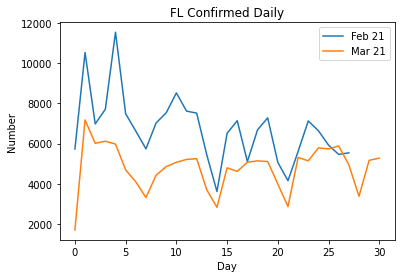

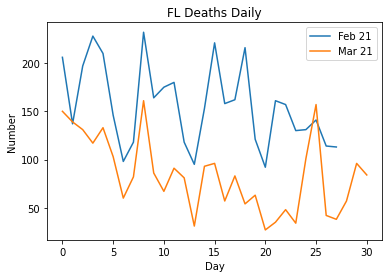

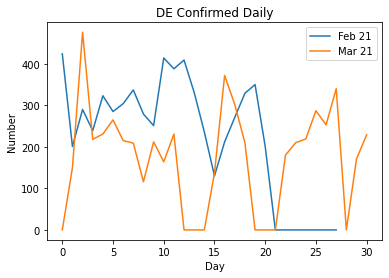

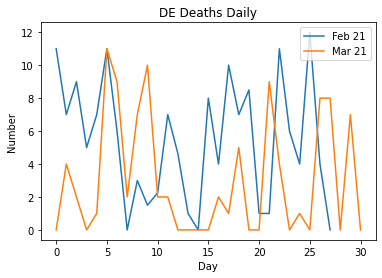

In [19]:
fl_confirmed_daily_feb21 = fl_confirmed_daily[date_index('2021-02-01'):date_index('2021-03-01')]
fl_confirmed_daily_mar21 = fl_confirmed_daily[date_index('2021-03-01'):date_index('2021-04-01')]
fl_deaths_daily_feb21 = fl_deaths_daily[date_index('2021-02-01'):date_index('2021-03-01')]
fl_deaths_daily_mar21 = fl_deaths_daily[date_index('2021-03-01'):date_index('2021-04-01')]

de_confirmed_daily_feb21 = de_confirmed_daily[date_index('2021-02-01'):date_index('2021-03-01')]
de_confirmed_daily_mar21 = de_confirmed_daily[date_index('2021-03-01'):date_index('2021-04-01')]
de_deaths_daily_feb21 = de_deaths_daily[date_index('2021-02-01'):date_index('2021-03-01')]
de_deaths_daily_mar21 = de_deaths_daily[date_index('2021-03-01'):date_index('2021-04-01')]

plt.figure()
plt.plot(range(28), fl_confirmed_daily_feb21, label='Feb 21')
plt.plot(range(31), fl_confirmed_daily_mar21, label='Mar 21')
plt.title('FL Confirmed Daily')
plt.xlabel('Day')
plt.ylabel('Number')
plt.legend(loc='upper right')
plt.show()

plt.figure()
plt.plot(range(28), fl_deaths_daily_feb21, label='Feb 21')
plt.plot(range(31), fl_deaths_daily_mar21, label='Mar 21')
plt.title('FL Deaths Daily')
plt.xlabel('Day')
plt.ylabel('Number')
plt.legend(loc='upper right')
plt.show()

plt.figure()
plt.plot(range(28), de_confirmed_daily_feb21, label='Feb 21')
plt.plot(range(31), de_confirmed_daily_mar21, label='Mar 21')
plt.title('DE Confirmed Daily')
plt.xlabel('Day')
plt.ylabel('Number')
plt.legend(loc='upper right')
plt.show()

plt.figure()
plt.plot(range(28), de_deaths_daily_feb21, label='Feb 21')
plt.plot(range(31), de_deaths_daily_mar21, label='Mar 21')
plt.title('DE Deaths Daily')
plt.xlabel('Day')
plt.ylabel('Number')
plt.legend(loc='upper right')
plt.show()

In [20]:
def get_corrected_std(data):
    n = len(data)
    sum = 0
    mean = np.mean(data)
    for x in data:
        sum += (x - mean) ** 2
    return np.sqrt(sum/(n-1))

In [21]:
def get_uncorrected_std(data):
    n = len(data)
    sum = 0
    mean = np.mean(data)
    for x in data:
        sum += (x - mean) ** 2
    return np.sqrt(sum/n)

## One Sample Wald's Test

In [22]:
def walds_test_1(data, theta0, threshold):
    mean = np.mean(data)
    n = len(data)
    w = mean - theta0
    w = w / np.sqrt(mean/n)
    w = abs(w)

    if w > threshold:
        # reject H0: theta = theta0
        print('|W| =', w, '>', threshold, ', thus reject H0, theta != theta0')
    else:
        # accept H0: theta != theta0
        print('|W| =', w, '<=', threshold, ', thus accept H0, theta = theta0')


In [23]:
print('\nFL Confirmed Daily')
walds_test_1(fl_confirmed_daily_mar21, np.mean(fl_confirmed_daily_feb21), 1.96)

print('\nFL Deaths Daily')
walds_test_1(fl_deaths_daily_mar21, np.mean(fl_deaths_daily_feb21), 1.96)

print('\nDE Confirmed Daily')
walds_test_1(de_confirmed_daily_mar21, np.mean(de_confirmed_daily_feb21), 1.96)

print('\nDE Deaths Daily')
walds_test_1(de_deaths_daily_mar21, np.mean(de_deaths_daily_feb21), 1.96)


FL Confirmed Daily
|W| = 154.00699922906583 > 1.96 , thus reject H0, theta != theta0

FL Deaths Daily
|W| = 44.066109897784024 > 1.96 , thus reject H0, theta != theta0

DE Confirmed Daily
|W| = 20.033060218514848 > 1.96 , thus reject H0, theta != theta0

DE Deaths Daily
|W| = 7.504756829872881 > 1.96 , thus reject H0, theta != theta0


Applicability: 
- $\hat{\theta}$ is AN, since we use MLE for Wald's test as the estimator.
- Thus the test is applicable.

## One Sample Z-test

In [24]:
def z_test_1(data, u0, sigma, threshold):
    mean = np.mean(data)
    n = len(data)

    z = mean - u0
    z = z / (sigma / np.sqrt(n))
    z = abs(z)

    if z > threshold:
        # reject H0: mu = mu0
        print('|Z| =', z, '>', threshold, ', thus reject H0, mu != mu0')
    else:
        # accept H0: mu != mu0
        print('|Z| =', z, '<=', threshold, ', thus accept H0, mu = mu0')

In [25]:
print('\nFL Confirmed Daily')
z_test_1(fl_confirmed_daily_mar21, np.mean(fl_confirmed_daily_feb21), get_corrected_std(fl_confirmed_daily), 1.96)

print('\nFL Deaths Daily')
z_test_1(fl_deaths_daily_mar21, np.mean(fl_deaths_daily_feb21), get_corrected_std(fl_deaths_daily), 1.96)

print('\nDE Confirmed Daily')
z_test_1(de_confirmed_daily_mar21, np.mean(de_confirmed_daily_feb21), get_corrected_std(de_confirmed_daily), 1.96)

print('\nDE Deaths Daily')
z_test_1(de_deaths_daily_mar21, np.mean(de_deaths_daily_feb21), get_corrected_std(de_deaths_daily), 1.96)


FL Confirmed Daily
|Z| = 2.517436185080843 > 1.96 , thus reject H0, mu != mu0

FL Deaths Daily
|Z| = 6.538899043920793 > 1.96 , thus reject H0, mu != mu0

DE Confirmed Daily
|Z| = 1.4461925149404402 <= 1.96 , thus accept H0, mu = mu0

DE Deaths Daily
|Z| = 4.119543506529116 > 1.96 , thus reject H0, mu != mu0


Applicability: 
- Z-test is applicable when n is large. But in this case n=31, we cannot say it large enough.
- Thus the test is not applicable.

## One Sample T-test

In [26]:
def t_test_1(data, u0, threshold):
    mean = np.mean(data)
    n = len(data)

    t = mean - u0
    t = t / (get_corrected_std(data) / np.sqrt(n))
    t = abs(t)

    if t > threshold:
        # reject H0: mu = mu0
        print('|T| =', t, '>', threshold, ', thus reject H0, mu != mu0')
    else:
        # accept H0: mu != mu0
        print('|T| =', t, '<=', threshold, ', thus accept H0, mu = mu0')

In [27]:
# t(30, 0.05/2) ~= 2.04

print('\nFL Confirmed Daily')
t_test_1(fl_confirmed_daily_mar21, np.mean(fl_confirmed_daily_feb21), 2.04)

print('\nFL Deaths Daily')
t_test_1(fl_deaths_daily_mar21, np.mean(fl_deaths_daily_feb21), 2.04)

print('\nDE Confirmed Daily')
t_test_1(de_confirmed_daily_mar21, np.mean(de_confirmed_daily_feb21), 2.04)

print('\nDE Deaths Daily')
t_test_1(de_deaths_daily_mar21, np.mean(de_deaths_daily_feb21), 2.04)


FL Confirmed Daily
|T| = 9.378422030507105 > 2.04 , thus reject H0, mu != mu0

FL Deaths Daily
|T| = 10.388393069005474 > 2.04 , thus reject H0, mu != mu0

DE Confirmed Daily
|T| = 2.1124218843871345 > 2.04 , thus reject H0, mu != mu0

DE Deaths Daily
|T| = 3.6075061712377248 > 2.04 , thus reject H0, mu != mu0


Applicability:
- T-test is applicable when data are normally distributed. It is not in this case.
- Thus this test is not applicable.

## Two Sample Wald's Test

In [28]:
def walds_test_2(x, y, threshold):
    n = len(x)
    m = len(y)
    x_mean = np.mean(x)
    y_mean = np.mean(y)

    w = x_mean - y_mean
    w = w / np.sqrt(x_mean/n + y_mean/m)
    w = abs(w)

    if w > threshold:
        # reject H0: theta0 = theta1
        print('|W| =', w, '>', threshold, ', thus reject H0, theta0 != theta1')
    else:
        # accept H0: theta0 != theta1
        print('|W| =', w, '<=', threshold, ', thus accept H0, theta0 = theta1')

In [29]:
print('\nFL Confirmed Daily')
walds_test_2(fl_confirmed_daily_mar21, fl_confirmed_daily_feb21, 1.96)

print('\nFL Deaths Daily')
walds_test_2(fl_deaths_daily_mar21, fl_deaths_daily_feb21, 1.96)

print('\nDE Confirmed Daily')
walds_test_2(de_confirmed_daily_mar21, de_confirmed_daily_feb21, 1.96)

print('\nDE Deaths Daily')
walds_test_2(de_deaths_daily_mar21, de_deaths_daily_feb21, 1.96)


FL Confirmed Daily
|W| = 96.45320339102717 > 1.96 , thus reject H0, theta0 != theta1

FL Deaths Daily
|W| = 25.17243031843485 > 1.96 , thus reject H0, theta0 != theta1

DE Confirmed Daily
|W| = 12.906970106995074 > 1.96 , thus reject H0, theta0 != theta1

DE Deaths Daily
|W| = 4.362337488195578 > 1.96 , thus reject H0, theta0 != theta1


Applicability:
- Two populated Wald's test is applicable when two datas are independent. In this case we can say it fits.
- Thus the test is applicable.

## Two Sample Unpaired T-test

In [30]:
def t_test_2(x, y, threshold):
    n = len(x)
    m = len(y)
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    x_s2 = get_corrected_std(x) ** 2
    y_s2 = get_corrected_std(y) ** 2

    t = x_mean - y_mean
    t = t / np.sqrt(x_s2/n + y_s2/m)
    t = abs(t)

    if t > threshold:
        # reject H0: mu0 = mu1
        print('|T| =', t, '>', threshold, ', thus reject H0, mu0 != mu1')
    else:
        # accept H0: mu0 != mu1
        print('|T| =', t, '<=', threshold, ', thus accept H0, mu0 = mu1')

In [31]:
# t(30, 0.05/2) ~= 2.04

print('\nFL Confirmed Daily')
t_test_2(fl_confirmed_daily_mar21, fl_confirmed_daily_feb21, 2.04)

print('\nFL Deaths Daily')
t_test_2(fl_deaths_daily_mar21, fl_deaths_daily_feb21, 2.04)

print('\nDE Confirmed Daily')
t_test_2(de_confirmed_daily_mar21, de_confirmed_daily_feb21, 2.04)

print('\nDE Deaths Daily')
t_test_2(de_deaths_daily_mar21, de_deaths_daily_feb21, 2.04)


FL Confirmed Daily
|T| = 5.086801893689198 > 2.04 , thus reject H0, mu0 != mu1

FL Deaths Daily
|T| = 6.847398048523643 > 2.04 , thus reject H0, mu0 != mu1

DE Confirmed Daily
|T| = 1.330939688448386 <= 2.04 , thus accept H0, mu0 = mu1

DE Deaths Daily
|T| = 2.4424131597900365 > 2.04 , thus reject H0, mu0 != mu1


Applicability:
- Two-sample unpaired T-test is applicable when 2 datas are normally distributed. It is not in this case.
- Thus the test is not applicable.

# 2c: Inference of Equality

## Data

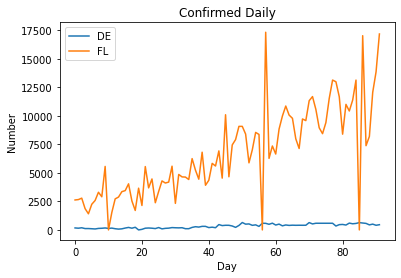

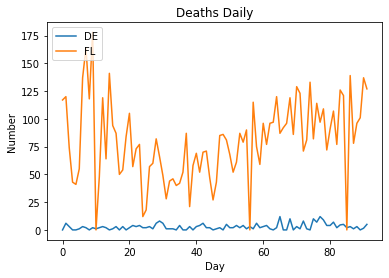

In [32]:
fl_confirmed_daily_3month = fl_confirmed_daily[date_index('2020-10-01'): date_index('2021-01-01')]
fl_deaths_daily_3month = fl_deaths_daily[date_index('2020-10-01'): date_index('2021-01-01')]

de_confirmed_daily_3month = de_confirmed_daily[date_index('2020-10-01'): date_index('2021-01-01')]
de_deaths_daily_3month = de_deaths_daily[date_index('2020-10-01'): date_index('2021-01-01')]

plt.figure()
plt.plot(range(len(de_confirmed_daily_3month)), de_confirmed_daily_3month, label='DE')
plt.plot(range(len(fl_confirmed_daily_3month)), fl_confirmed_daily_3month, label='FL')
plt.title('Confirmed Daily')
plt.xlabel('Day')
plt.ylabel('Number')
plt.legend(loc='upper left')
plt.show()

plt.figure()
plt.plot(range(len(de_deaths_daily_3month)), de_deaths_daily_3month, label='DE')
plt.plot(range(len(fl_deaths_daily_3month)), fl_deaths_daily_3month, label='FL')
plt.title('Deaths Daily')
plt.xlabel('Day')
plt.ylabel('Number')
plt.legend(loc='upper left')
plt.show()

## 2-Sample K-S Test

In [33]:
def get_eCDF(sample, x):
    n = len(sample)
    count = 0
    for d in sample:
        if d <= x:
            count += 1
    return count/n

In [34]:
def ks_test_2(data1, data2, plt_title, threshold):
    x = []
    for i in range(-1, int(np.max(data1+data2)) * 10 + 10):
        x.append(i/10)
    
    y1 = []
    y2 = []
    max_dif = 0
    max_dif_x = 0
    max_dif_y1 = 0
    max_dif_y2 = 0

    for xi in x:
        eCDF_1 = get_eCDF(data1, xi)
        eCDF_2 = get_eCDF(data2, xi)
        dif = abs(eCDF_1 - eCDF_2)
        if (dif > max_dif):
            max_dif = dif
            max_dif_x = xi
            max_dif_y1 = eCDF_1
            max_dif_y2 = eCDF_2
        y1.append(eCDF_1)
        y2.append(eCDF_2)

    plt.figure(figsize=(12,10))
    plt.plot(x, y1, label='DE')
    plt.plot(x, y2, label='FL')
    plt.plot([max_dif_x, max_dif_x], [max_dif_y1, max_dif_y2], label='Max Difference='+str(max_dif)+' at x='+str(max_dif_x))
    plt.xlabel('Day')
    plt.ylabel('eCDF')
    plt.title(plt_title)
    plt.legend()
    plt.show()

    if max_dif > threshold:
        # reject H0: F_x != F_y
        print('d =', max_dif, '>', threshold, ', thus reject H0, F_x != F_y\n')
    else:
        # accept H0: F_x = F_y
        print('d =', max_dif, '<=', threshold, ', thus accept H0, F_x = F_y\n')

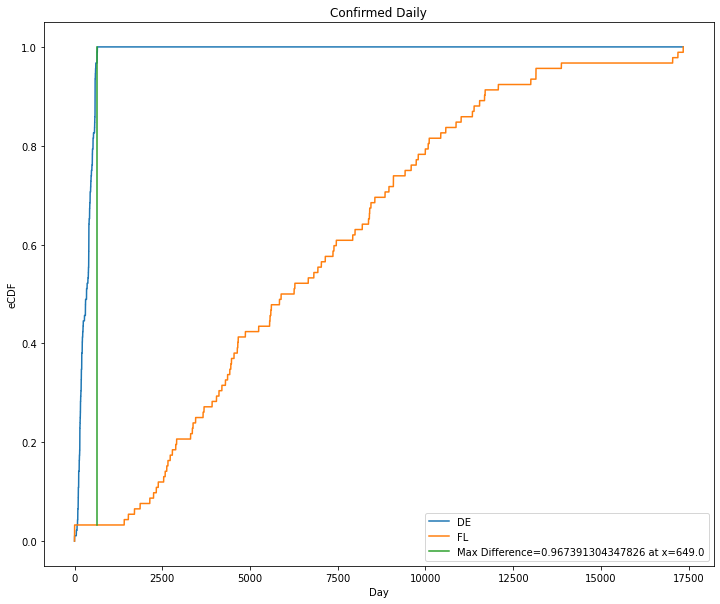

d = 0.967391304347826 > 0.05 , thus reject H0, F_x != F_y



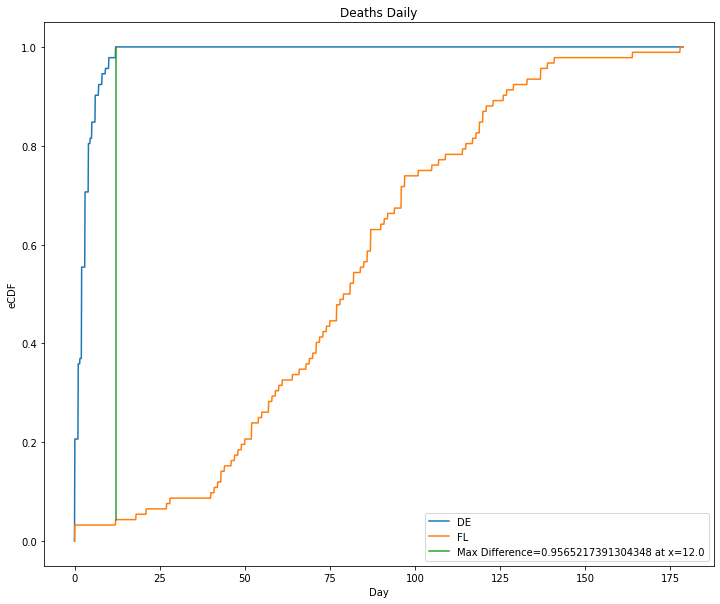

d = 0.9565217391304348 > 0.05 , thus reject H0, F_x != F_y



In [35]:
ks_test_2(de_confirmed_daily_3month, fl_confirmed_daily_3month, 'Confirmed Daily', 0.05)
ks_test_2(de_deaths_daily_3month, fl_deaths_daily_3month, 'Deaths Daily', 0.05)

## 1-Sample K-S Test: Poisson
- $\hat \lambda_{MME}  = \bar{X}$

In [36]:
def ks_test_poisson(data, lam, plt_title, threshold):
    x = []
    for i in range(-1, int(np.max(data)) * 10 + 10):
        x.append(i/10)
    
    y1 = []
    y2 = []
    max_dif = 0
    max_dif_x = 0
    max_dif_y1 = 0
    max_dif_y2 = 0

    for xi in x:
        eCDF_1 = get_eCDF(data, xi)
        eCDF_2 = scipy.stats.poisson.cdf(xi, lam)
        dif = abs(eCDF_1 - eCDF_2)
        if (dif > max_dif):
            max_dif = dif
            max_dif_x = xi
            max_dif_y1 = eCDF_1
            max_dif_y2 = eCDF_2
        y1.append(eCDF_1)
        y2.append(eCDF_2)

    plt.figure(figsize=(12,10))
    plt.plot(x, y1, label='FL')
    plt.plot(x, y2, label='Poisson')
    plt.plot([max_dif_x, max_dif_x], [max_dif_y1, max_dif_y2], label='Max Difference='+str(max_dif)+' at x='+str(max_dif_x))
    plt.xlabel('Day')
    plt.ylabel('eCDF')
    plt.title(plt_title)
    plt.legend()
    plt.show()

    if max_dif > threshold:
        # reject H0: F_x != F_y
        print('d =', max_dif, '>', threshold, ', thus reject H0, F_x != Poisson(' + str(lam) + ')\n')
    else:
        # accept H0: F_x = F_y
        print('d =', max_dif, '<=', threshold, ', thus accept H0, F_x = Poisson(' + str(lam) + ')\n')

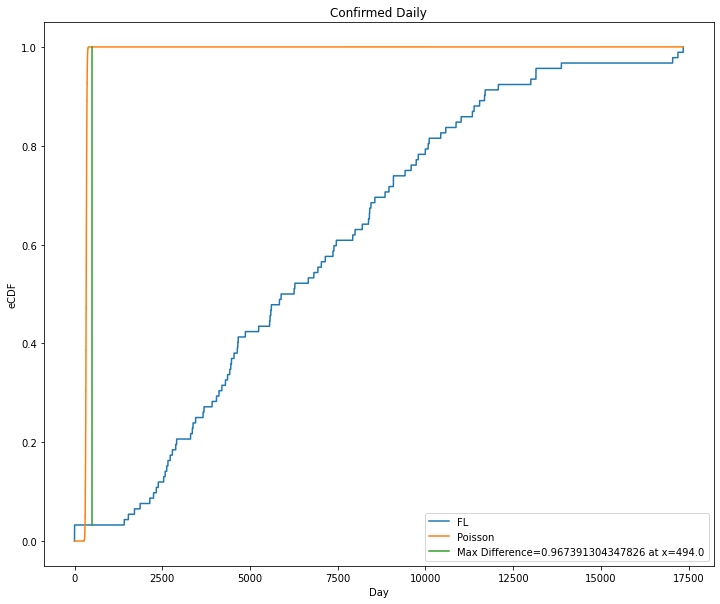

d = 0.967391304347826 > 0.05 , thus reject H0, F_x != Poisson(331.9381103515625)



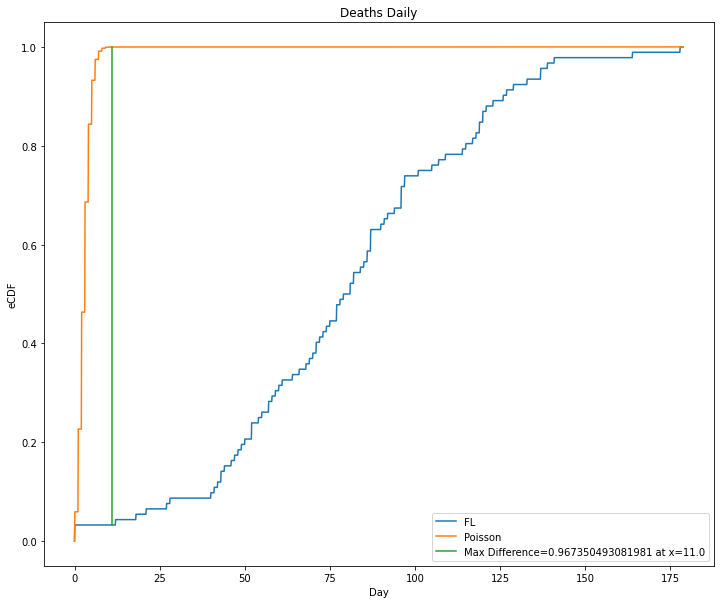

d = 0.967350493081981 > 0.05 , thus reject H0, F_x != Poisson(2.8260869565217392)



In [37]:
ks_test_poisson(fl_confirmed_daily_3month, np.mean(de_confirmed_daily_3month), 'Confirmed Daily', 0.05)
ks_test_poisson(fl_deaths_daily_3month, np.mean(de_deaths_daily_3month), 'Deaths Daily', 0.05)

## 1-Sample K-S Test: Geometric
- $\hat{p}_{MME} = \frac{1}{\bar{X}}$

In [38]:
def ks_test_geometric(data, p, plt_title, threshold):
    x = []
    for i in range(-1, int(np.max(data)) * 10 + 10):
        x.append(i/10)
    
    y1 = []
    y2 = []
    max_dif = 0
    max_dif_x = 0
    max_dif_y1 = 0
    max_dif_y2 = 0

    for xi in x:
        eCDF_1 = get_eCDF(data, xi)
        eCDF_2 = scipy.stats.geom.cdf(xi, p)
        dif = abs(eCDF_1 - eCDF_2)
        if (dif > max_dif):
            max_dif = dif
            max_dif_x = xi
            max_dif_y1 = eCDF_1
            max_dif_y2 = eCDF_2
        y1.append(eCDF_1)
        y2.append(eCDF_2)

    plt.figure(figsize=(12,10))
    plt.plot(x, y1, label='FL')
    plt.plot(x, y2, label='Geometric')
    plt.plot([max_dif_x, max_dif_x], [max_dif_y1, max_dif_y2], label='Max Difference='+str(max_dif)+' at x='+str(max_dif_x))
    plt.xlabel('Day')
    plt.ylabel('eCDF')
    plt.title(plt_title)
    plt.legend()
    plt.show()

    if max_dif > threshold:
        # reject H0: F_x != F_y
        print('d =', max_dif, '>', threshold, ', thus reject H0, F_x != Geometric(' + str(p) + ')\n')
    else:
        # accept H0: F_x = F_y
        print('d =', max_dif, '<=', threshold, ', thus accept H0, F_x = Geometric(' + str(p) + ')\n')

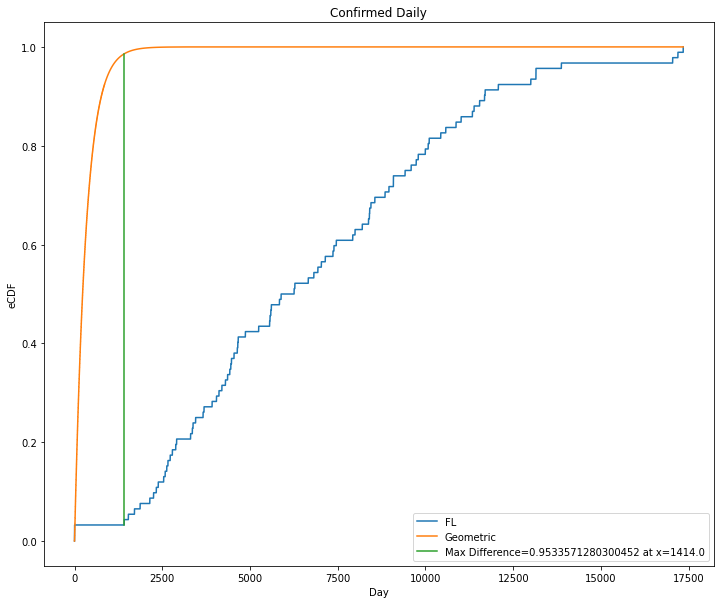

d = 0.9533571280300452 > 0.05 , thus reject H0, F_x != Geometric(0.003012609787230756)



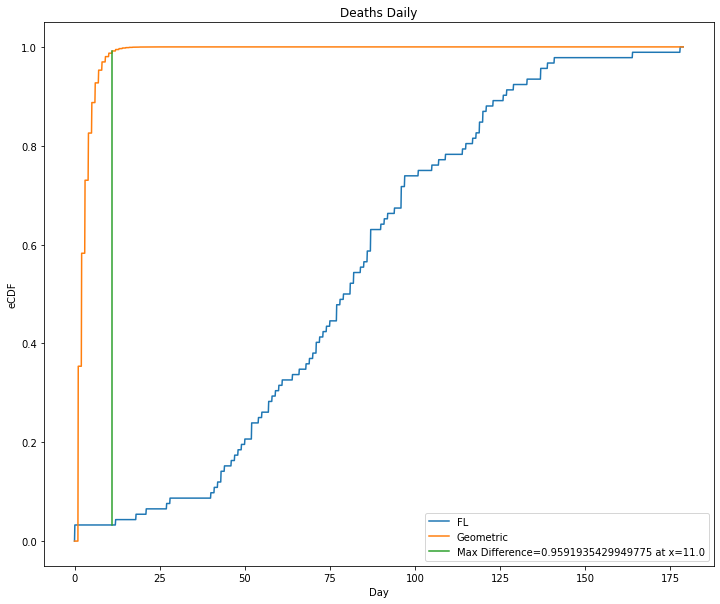

d = 0.9591935429949775 > 0.05 , thus reject H0, F_x != Geometric(0.3538461538461538)



In [39]:
ks_test_geometric(fl_confirmed_daily_3month, 1/np.mean(de_confirmed_daily_3month), 'Confirmed Daily', 0.05)
ks_test_geometric(fl_deaths_daily_3month, 1/np.mean(de_deaths_daily_3month), 'Deaths Daily', 0.05)

## 1-sample K-S Test: Binomial
- $\hat p_{MME} = 1 - \frac{s^2}{\bar{X}}$
- $\hat n_{MME} = \frac{\bar{X}^2}{\bar{X} - s^2} = \frac{\bar{X}}{p_{MME}}$

In [40]:
def ks_test_binomial(data, data2, plt_title, threshold):
    x_bar = np.mean(data2)
    s2 = np.var(data2)
    n = (x_bar ** 2) / (x_bar - s2)
    p = 1 - (s2 / x_bar)

    x = []
    for i in range(int(np.max(data)) * 10 + 10):
        x.append(i/10)
    
    y1 = []
    y2 = []
    max_dif = 0
    max_dif_x = 0
    max_dif_y1 = 0
    max_dif_y2 = 0

    for xi in x:
        eCDF_1 = get_eCDF(data, xi)
        eCDF_2 = scipy.stats.binom.cdf(xi, n, p)
        dif = abs(eCDF_1 - eCDF_2)
        if (dif > max_dif):
            max_dif = dif
            max_dif_x = xi
            max_dif_y1 = eCDF_1
            max_dif_y2 = eCDF_2
        y1.append(eCDF_1)
        y2.append(eCDF_2)

    plt.figure(figsize=(12,10))
    plt.plot(x, y1, label='FL')
    plt.plot(x, y2, label='Geometric')
    plt.plot([max_dif_x, max_dif_x], [max_dif_y1, max_dif_y2], label='Max Difference='+str(max_dif)+' at x='+str(max_dif_x))
    plt.xlabel('Day')
    plt.ylabel('eCDF')
    plt.title(plt_title)
    plt.legend()
    plt.show()

    if max_dif > threshold:
        # reject H0: F_x != F_y
        print('d =', max_dif, '>', threshold, ', thus reject H0, F_x != Binomial(' + str(n) + ',' + str(p) + ')\n')
    else:
        # accept H0: F_x = F_y
        print('d =', max_dif, '<=', threshold, ', thus accept H0, F_x = Binomial(' + str(n) + ',' + str(p) + ')\n')

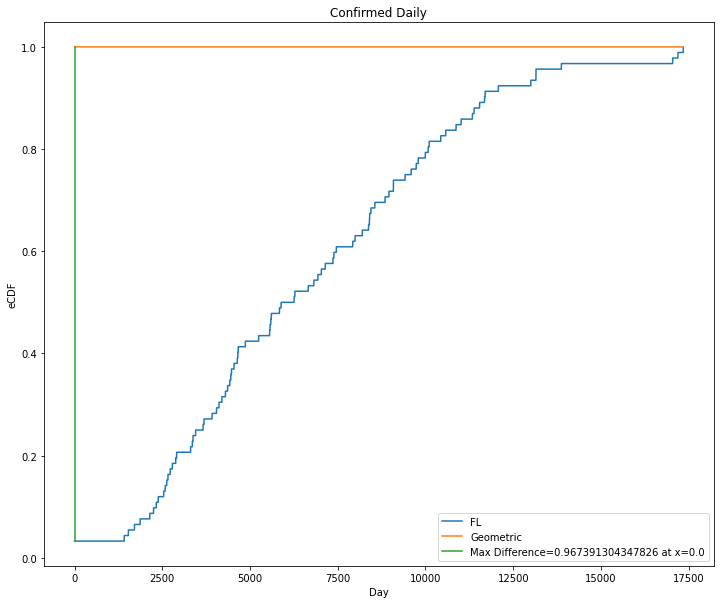

d = 0.967391304347826 > 0.05 , thus reject H0, F_x != Binomial(-3.4167112951461887,-97.15134867353787)



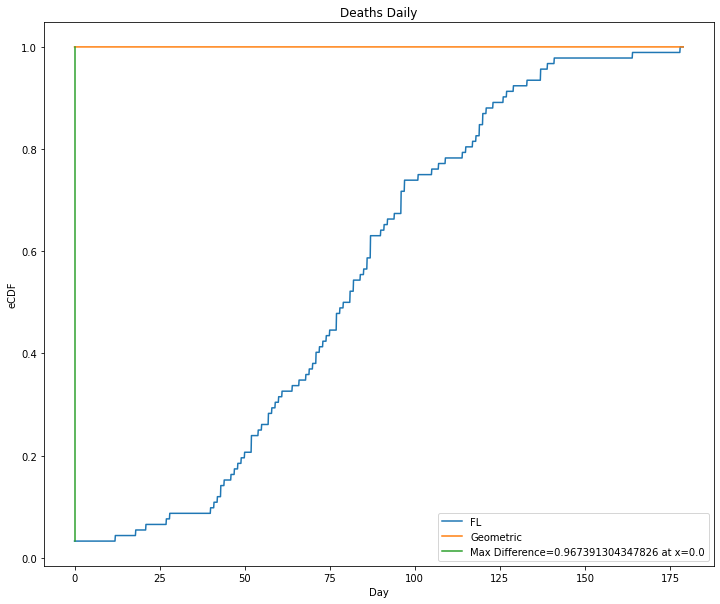

d = 0.967391304347826 > 0.05 , thus reject H0, F_x != Binomial(-1.709920574695199,-1.6527591973244151)



In [41]:
ks_test_binomial(fl_confirmed_daily_3month, de_confirmed_daily_3month, 'Confirmed Daily', 0.05)
ks_test_binomial(fl_deaths_daily_3month, de_deaths_daily_3month, 'Deaths Daily', 0.05)

## Permutation Test

In [42]:
def get_permutation(data0, data1):
    data = data0 + data1
    data = np.random.permutation(data)
    n = len(data0)
    x = data[:n]
    y = data[n:]
    return (x,y)

In [43]:
def permutation_test(a1, a2, s, threshold):
    t_obs = abs(np.mean(a1) - np.mean(a2))
    count = 0
    for i in range(s):
        (x, y) = get_permutation(a1, a2)
        t = abs(np.mean(x) - np.mean(y))
        if t > t_obs:
            count += 1
    p_value = count/s
    if p_value <= threshold:
        # reject H0: F_x != F_y
        print('p-value =', p_value, '<=', threshold, ', thus reject H0, F_x != F_y')
    else:
        # accept H0: F_x = F_y
        print('p-value =', p_value, '>', threshold, ', thus accept H0, F_x = F_y')

In [44]:
print('\nConfirmd Daily')
permutation_test(fl_confirmed_daily_3month, de_confirmed_daily_3month, 1000, 0.05)
print('\nDeaths Daily')
permutation_test(fl_deaths_daily_3month, de_deaths_daily_3month, 1000, 0.05)


Confirmd Daily
p-value = 0.0 <= 0.05 , thus reject H0, F_x != F_y

Deaths Daily
p-value = 0.0 <= 0.05 , thus reject H0, F_x != F_y


# 2d: Bayesian Inference
- We can treat $Exp(\lambda)$ as $Gamma(1, \lambda)$
- The Poisson and Gamma families of distributions are a conjugate pair
- Thus, posterior of $\lambda \sim Gamma(\alpha^*, \beta^*)$, where $\alpha^* = \alpha + \sum X_i, \beta^* = \frac{\beta}{1+n\beta} = \frac{\bar X}{1+n\bar X}$

In [45]:
def plot_gamma(alpha, beta, plt_label):
    x = np.linspace(scipy.stats.gamma.ppf(0.01, alpha, scale=beta),scipy.stats.gamma.ppf(0.99, alpha, scale=beta), 100)
    y = scipy.stats.gamma.pdf(x, alpha, scale=beta)
    map = (alpha - 1) * beta
    plt.plot(x,y, label=plt_label+', MAP='+ str(map))

In [46]:
def beyasian_inference(data0, data1, plt_title):
    alpha = 1
    beta = np.mean(data0)

    plt.figure(figsize=(12,10))
    # plot_gamma(alpha, beta, 'Prior: Week 1-4')
    for i in range(len(data1)):
        data0 = np.append(data0, data1[i])

        sum = np.sum(data0)
        n = len(data0)
        mean = sum / n

        alpha = 1 + sum
        beta = mean / (1 + n*mean)
        plot_gamma(alpha, beta, 'Posterior: Week '+str(5+i))
    plt.xlabel('Number')
    plt.ylabel('PDF of Posterior')
    plt.title(plt_title)
    plt.legend(loc='upper right')
    plt.show()

In [47]:
confirmed_week14 = np.add(de_confirmed_daily[date_index('2020-06-01'): date_index('2020-06-29')], fl_confirmed_daily[date_index('2020-06-01'): date_index('2020-06-29')])
confirmed_week58 = []
for i in range(4):
    confirmed_week58.append(np.add(de_confirmed_daily[date_index('2020-06-29')+7*i: date_index('2020-07-06')+7*i], fl_confirmed_daily[date_index('2020-06-29')+7*i: date_index('2020-07-06')+7*i]))

deaths_week14 = np.add(de_deaths_daily[date_index('2020-06-01'): date_index('2020-06-29')], fl_deaths_daily[date_index('2020-06-01'): date_index('2020-06-29')])
deaths_week58 = []
for i in range(4):
    deaths_week58.append(np.add(de_deaths_daily[date_index('2020-06-29')+7*i: date_index('2020-07-06')+7*i], fl_deaths_daily[date_index('2020-06-29')+7*i: date_index('2020-07-06')+7*i]))

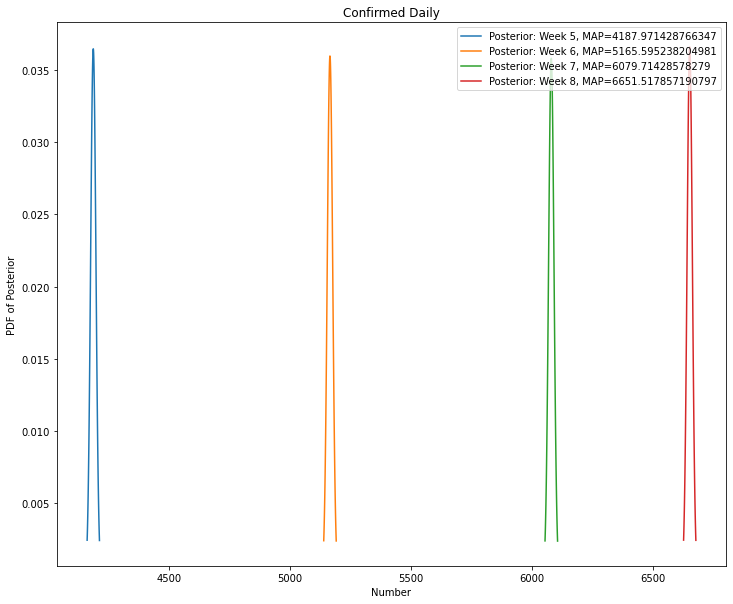

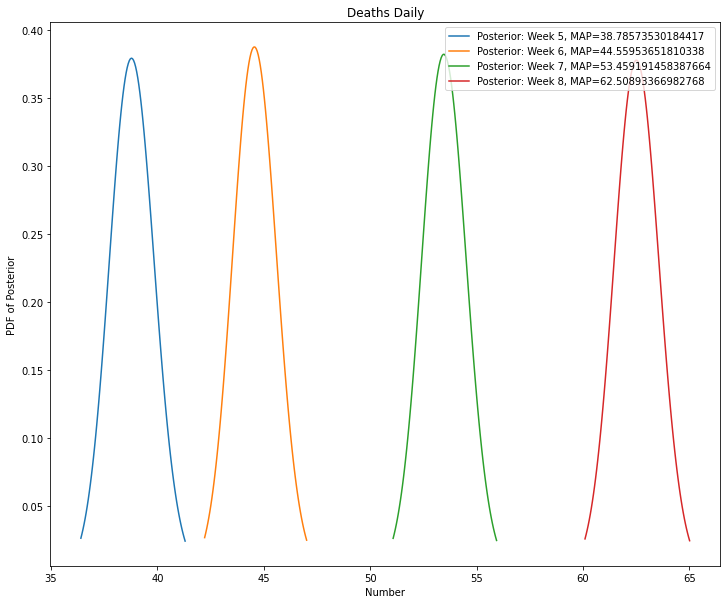

In [48]:
beyasian_inference(confirmed_week14, confirmed_week58, 'Confirmed Daily')
beyasian_inference(deaths_week14, deaths_week58, 'Deaths Daily')

# 3a: Does X-data Impacted

In [49]:
def date_index_slash(date_string):
    date = date_string.split('/')
    month = int(date[0])
    day = int(date[1])
    year = int(date[2])
    d1 = datetime.datetime(2020, 1, 22)
    d2 = datetime.datetime(year, month, day)
    return (d2 - d1).days

# Since the stock market closed for weekends and vacations, we need to fill those days with latest available price.
def fill_stock(date, price_without_weekends):
    price = []
    latest_date = -1
    for i in range(len(date)):
        d = date[i]
        for j in range(d - latest_date):
            price.append(price_without_weekends[i])
        latest_date = d
    return price

In [50]:
zoom_price_without_weekends = []
stock_date = []
csv_file=open('Datasets/X-dataset/Zoom Price.csv')
csv_reader_lines = csv.reader(csv_file)
for one_line in csv_reader_lines:
    if one_line[0]!='Date':
        stock_date.append(date_index_slash(one_line[0]))
        zoom_price_without_weekends.append(float(one_line[4]))
        
zoom_price = fill_stock(stock_date, zoom_price_without_weekends)
zoom_price.append(zoom_price[-1])
zoom_price.append(zoom_price[-1])

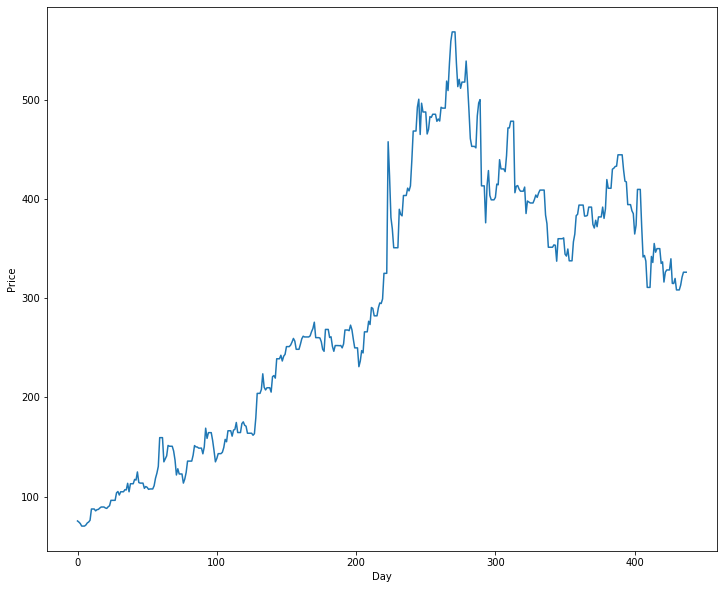

In [51]:
plt.figure(figsize=(12,10))
plt.plot(range(len(zoom_price)), zoom_price)
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

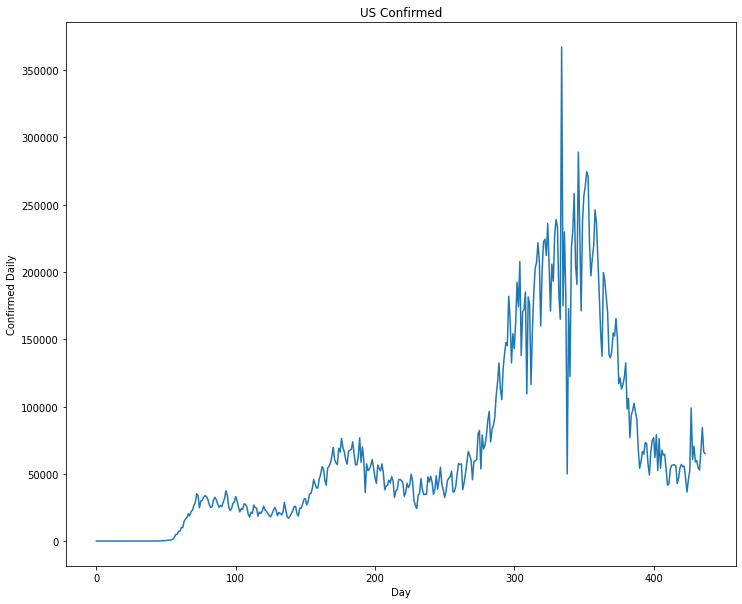

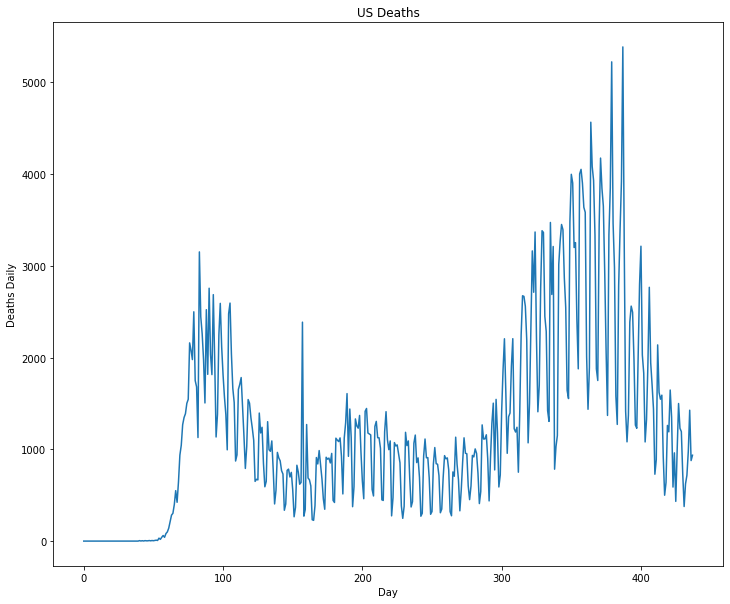

In [52]:
us_confirmed = [0]*(date_index('2021-04-03') - date_index('2020-01-22') + 1)
csv_file=open('Datasets/US-all/US_confirmed.csv')
csv_reader_lines = csv.reader(csv_file)
for one_line in csv_reader_lines:
    if one_line[0]!='State':
        for i in range(1, len(one_line)):
            us_confirmed[i-1] += int(one_line[i])

us_deaths = [0]*(date_index('2021-04-03') - date_index('2020-01-22') + 1)
csv_file=open('Datasets/US-all/US_deaths.csv')
csv_reader_lines = csv.reader(csv_file)
for one_line in csv_reader_lines:
    if one_line[0]!='State':
        for i in range(1, len(one_line)):
            us_deaths[i-1] += int(one_line[i])

us_confirmed_daily = [0]
us_deaths_daily = [0]
for i in range(1, len(us_confirmed)):
    us_confirmed_daily.append(us_confirmed[i] - us_confirmed[i-1])
    us_deaths_daily.append(us_deaths[i] - us_deaths[i-1])

plt.figure(figsize=(12,10))
plt.plot(range(len(us_confirmed_daily)), us_confirmed_daily)
plt.title('US Confirmed')
plt.xlabel('Day')
plt.ylabel('Confirmed Daily')
plt.show()

plt.figure(figsize=(12,10))
plt.plot(range(len(us_deaths_daily)), us_deaths_daily)
plt.title('US Deaths')
plt.xlabel('Day')
plt.ylabel('Deaths Daily')
plt.show()

In [53]:
def pearsons_correlation_coefficient(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    sum0 = 0
    sum1 = 0
    sum2 = 0
    for i in range(len(x)):
        sum0 += (x[i] - x_mean) * (y[i] - y_mean)
        sum1 += (x[i] - x_mean) ** 2
        sum2 += (y[i] - y_mean) ** 2
    pho = sum0 / (np.sqrt(sum1 * sum2))
    return pho

In [54]:
def pearsons_test(x, y, threshold):
    pho = pearsons_correlation_coefficient(x,y)

    if abs(pho) > threshold:
        # reject H0
        if pho > 0.5:
            print('Pho =', pho, '>', threshold, ', thus reject H0, X and Y are positive linear correlated.')
        else:
            print('Pho =', pho, '<', -threshold, ', thus reject H0, X and Y are positive linear correlated.')
    else:
        # accept H1
        print('|Pho| =', pho, '<=', threshold, ', thus accept H0, X and Y are not linear correlated.')

In [55]:
print('\nUS Confirmed Daily')
pearsons_test(zoom_price, us_confirmed_daily, 0.5)
print('\nUS Deaths Daily')
pearsons_test(zoom_price, us_deaths_daily, 0.5)


US Confirmed Daily
Pho = 0.571872419240749 > 0.5 , thus reject H0, X and Y are positive linear correlated.

US Deaths Daily
|Pho| = 0.33489946915500635 <= 0.5 , thus accept H0, X and Y are not linear correlated.


- H0: Zoom stock price and US #confirmed/deaths are not linear correlated.
- H1: Zoom stock price and US #confirmed/deaths are linear correlated.
- We use a threshold of 0.5 here.
- Results: we can say zoom stock price are positive linear correlated with US #confirmed but not linear correlated with US #deaths.

# 3b. If COVID19 Data Changed after Local Events
- Here we chose two events:
    - Lockdown, started since April 2020
    - Vaccine, started since Feb 2021

In [56]:
def walds_test_2_split(data, split_date, threshold):
    split = date_index(split_date)
    data0 = data[:split]
    data1 = data[split:]

    walds_test_2(data0, data1, 1.96)

In [57]:
print('\nUS Confirmed Daily')
walds_test_2_split(us_confirmed_daily, '2020-04-01', 1.96)

print('\nUS Deaths Daily')
walds_test_2_split(us_deaths_daily, '2020-04-01', 1.96)


US Confirmed Daily
|W| = 4883.045921168658 > 1.96 , thus reject H0, theta0 != theta1

US Deaths Daily
|W| = 637.0462969355976 > 1.96 , thus reject H0, theta0 != theta1


In [58]:
print('\nUS Confirmed Daily')
walds_test_2_split(us_confirmed_daily, '2021-02-01', 1.96)

print('\nUS Deaths Daily')
walds_test_2_split(us_deaths_daily, '2021-02-01', 1.96)


US Confirmed Daily
|W| = 29.551043251091972 > 1.96 , thus reject H0, theta0 != theta1

US Deaths Daily
|W| = 113.46029567063303 > 1.96 , thus reject H0, theta0 != theta1


- H0: mean of US #confirmed/deaths before the event = mean of US #confirmed/deaths after the event
- H1: mean of US #confirmed/deaths before the event != mean of US #confirmed/deaths after the event
- We chose 2-populated Wald's test.
- The result is that means are different as lockdown and vaccine started, which means they are useful.